**En numerisk tilnærming til dannelsen av membranløse organeller**

Mye av vitenskapens historie har vært dedikert til å undersøke og eksperimentere med universets minste byggeklosser. Fra Demokrits fire elementer, til 1900-tallets oppdagelse av kvarker, har fysikere forestilt seg verden som et eneste stort lego-sett. På en litt større skala kan vi si at levende organismer er bygget opp av celler, som igjen består av mindre bestanddeler. Eksempler på disse byggeklossene er mitokondrier og lysosomer, som begge har membraner (Gregers 2021).  

Andre bestanddeler i cellen derimot, som ribosomer, har ikke det. Blant disse membranløse delene finner vi også p-granuler, som dannes gjennom væske-væske-faseseparasjon (Bracha et. al. 2019). Dette er en tilstand hvor vi har en klar sameksistens av ulike væsker, for eksempel oljedråper i vann. 

Det er imidlertid ikke bare fysikkens måte å dele systemer opp i byggeklosser som er interessant når vi ser på celler, men også læren om elektrostatikk og statistisk fysikk. Ved hjelp av verktøy fra disse disiplinene kan vi for eksempel avgjøre hvilke strukturer som er energimessig gunstige når for eksempel p-granuler dannes. Dette vil igjen muliggjøre simuleringer av slike prosesser i cellene.  

I dette prosjektet ønsker vi derfor å undersøke dannelsen av membranløse organeller, ved å se på de elektrostatiske interaksjonene mellom biopolymerer i celler. Dette gjøres blant annet ved hjelp av Monte Carlo-simulasjoner, der energibetraktninger står sentralt. I disse simulasjonene foregår det tilfeldige bevegelser av bestanddeler, som det så avgjøres om skal gjennomføres, i henhold til visse regler. Til å begynne med ser vi på monomerer, små enheter som utgjør polymerer. Disse polymerene kan igjen gå sammen for å danne klynger, og videre organeller. 

In [1]:
import numpy as np
import random as rand

#For plotting and displaying graphs and animations
from matplotlib import colors
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, Image
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16, 'figure.titlesize': 18, 'animation.html': 'jshtml'})

#Needed to save our file:
from numpy.lib.npyio import NpzFile
from tempfile import TemporaryFile

#Jit
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

"""Since Python is based on English, it feels more natural to use English variable and function names. Therefore we have decided to comment our code, and name things, in English
throughout the project."""

'Since Python is based on English, it feels more natural to use English variable and function names. Therefore we have decided to comment our code, and name things, in English\nthroughout the project.'

For å kunne studere dette lager vi et kvadratisk N $\times$ N gitter, hvor hvert krysningspunkt på gitteret representerer enten et positivt eller negativt ladd monomer, eller nøytralt løsemiddel. Vi vil så plassere ut 2M monomerer tilfeldig på gitteret, hvor vi har M positivt ladde og M negativt ladde monomerer. Vi tilegner hvert monomer et unikt tall mellom –M og M, der fortegnet avgjør om det har ladning –e eller e, altså elementærladninga. Løsningsmiddelet tilegnes tallet 0. 

In [2]:
@jit(nopython=True)
def create_monomer_grid(N, M):
    assert 2*M <= N**2, "You've tried to place out more monomers than there are spaces availabøe"
    monomer_grid = np.zeros((N, N), dtype=np.dtype('i2'))
    monomer_value = 1
    while monomer_value <= M:
        for sign in [-1, 1]: #Decides the sign of the charge
            placed = False #to check if monomer has been placed successfully
            while not placed:
                i = rand.randint(0, N-1)
                j = rand.randint(0, N-1)
                if monomer_grid[i][j] == 0:
                    monomer_grid[i][j] = sign*monomer_value
                    placed = True
        monomer_value += 1
    #Optional test to ensure that 2M monomers have been placed:
    #monomers_placed= np.count_nonzero(monomer_grid)
    #print("Are there 2M nonzero elements: ", monomers_placed==2*M)
    return monomer_grid

Vi lager også en funksjon for å visualisere et monomersystem. Under arbeid med denne så vi også et behov for en standardiserings-funksjon, der vi bare ser på fortegnet til monomer-tallene. Det som startet som en ide for å kunne plotte monomerene uten nyanser innen samme ladning, viste seg også å være et nyttig verktøy for senere energibetraktninger. 

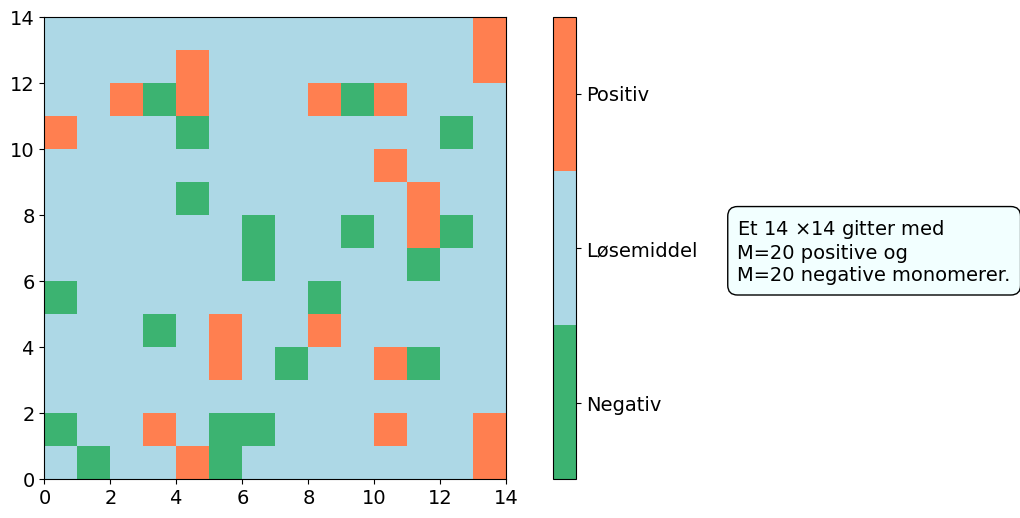

In [3]:
@jit(nopython=True)
def standardize_monomer_grid(grid):
    temporary_grid= grid.copy()
    length=len(grid)
    for i in range(length):
        for j in range(length):
            if temporary_grid[i][j]<-1:
                temporary_grid[i][j]=-1
            elif temporary_grid[i][j]>1:
                temporary_grid[i][j]=1
    return temporary_grid #Which only consists of -1, 0 and 1s

def colorplot(grid, colorbar=True):
    grid=grid[::-1,] 
    temporary_grid = standardize_monomer_grid(grid)
    N=len(grid)
    M=np.amax(grid)

    cmap = colors.ListedColormap(["mediumseagreen", "lightblue", "coral"])

    if colorbar:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.text(21, 6, f"Et {N}" + r" $\times$"+ f"{N} gitter med \nM={M} positive og\nM={M} negative monomerer.", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
        cax = ax.pcolormesh(temporary_grid, cmap = cmap)
        ax.axis("image")
        cbar = fig.colorbar(cax, ticks = [-0.67, 0, 0.67])
        cbar.ax.set_yticklabels(["Negativ", "Løsemiddel", "Positiv"])
        plt.show()
    else:
        plt.subplot(1,3,1)
        plt.pcolormesh(temporary_grid, cmap = cmap)
        plt.axis("image")

N=14
M=20

monomer_grid1b = create_monomer_grid(N,M)
colorplot(monomer_grid1b)

I disse energibetraktningene har vi valgt å bare se på elektrostatiske interaksjoner mellom monomerer som kan defineres som nærmeste naboer (NN). Med dette menes monomerer som har andre monomerer på nærmeste krysningspunkt fra seg, enten horisontalt eller vertikalt (ikke diagonalt).  

Antagelsen om at vi kan utelukke elektrostatiske krefter mellom andre monomerer, stammer fra at løsemiddelet vil svekke det elektriske feltet, siden epsilon_r er stor. Over lengre avstander antar vi at vi vil få et neglisjerbart bidrag i forhold til de nærmeste naboene. 

Det er derfor hensiktsmessig å definere en funksjon som returnerer koordinatene til alle de nærmeste naboene for et punkt. Vi ser også for oss at monomerene eksisterer på en torus. I praksis innebærer det at om vi beveger oss fra et punkt mot høyre, vil vi til slutt nærme oss samme punkt fra venstre; og om vi beveger oss oppover, vil vi til slutt komme opp fra nederste rad. 

Vi definerer så en funksjon for å beregne energien for et gitt monomer-system, der vi kun ser på elektrostatiske krefter mellom nærmeste naboer. 

In [4]:
@jit(nopython=True)
def nearestNeighbor(N, i, j): #i = row number, j = column number
    leftNN=[i, j-1]
    if j==N-1:          #Have to use use if sentences to account for boundary conditions
        rightNN=[i, 0]
    else:
        rightNN=[i, j+1]
    upperNN=[i-1, j]
    if i==N-1:
        lowerNN=[0, j]
    else:
        lowerNN=[i+1, j]
    arrayNN=np.array([rightNN, leftNN, upperNN, lowerNN], dtype=np.dtype('i2')) 
    return arrayNN

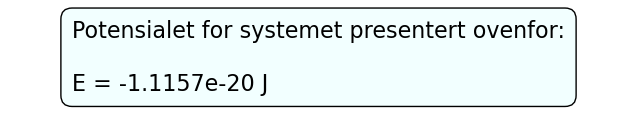

In [5]:
@jit(nopython=True)
def potential_for_monomersystem(monomer_grid):
    #We define necessary constants
    epsilon_r = 78 # The permittivitity of the solution
    a = 23E-6 # Distance between nearest neighbors
    epsilon_zero = 8.85E-12 # The permittivity of vacuum
    e = 1.6E-19 #Elementary charge
    alpha = e**2/(4*np.pi*epsilon_zero*epsilon_r*a**2) 
    standarized_grid = standardize_monomer_grid(monomer_grid)
    monomer_coordinates = np.argwhere(standarized_grid)  #Makes an array with the coordinates of the monomers
    N = len(standarized_grid)
    total_potential = 0
    for i, j in monomer_coordinates: # Where i and j represent the coordinates of the monomer
        NN_list = nearestNeighbor(N, i, j) #Makes an array with the positions of the NN for one non_zero element 
        for k, l in NN_list: # Coordinates of the NNs
            if monomer_grid[k][l] != 0: #Test if the neighbour is a monomer
                total_potential += standarized_grid[i][j] * standarized_grid[k][l] * alpha #Formula for the potential, with the standarized_grid[][] representing the charges of the monomers
    total_potential = total_potential / 2 #Accounts for counting the interactions between NNs twice
    return total_potential

plt.figure(figsize=(8,1.5))
plt.axis('off')
plt.text(0.1,0.3, f"Potensialet for systemet presentert ovenfor:\n\nE = {potential_for_monomersystem(monomer_grid1b):.4e} J", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.show()

Nå er vi klare for vår første Monte Carlo-simulasjon. Denne simulasjonen er en prosess bestående av flere såkalte MC-steg, hvor vi ønsker å fylle opp ei liste med energier. I hvert steg velges et monomer tilfeldig, og det forsøkes så å flytte det i en tilfeldig retning. Etter en slik bevegelse, tar programmet stilling til om dette er en tillatt bevegelse. Først sjekkes det om det er et annet monomer i den gitte retninga, og hvis det er det, avsluttes trinnet, og gitteret beholder sin opprinnelige konfigurasjon. Ellers sammenlignes energien i det nye og det gamle gitteret, og hvis den nye har lavere energi, velges denne. Vi har også en siste mulighet for å velge det nye gitteret, motivert av statistisk fysikk. Ved hjelp av den såkalte partisjonsfunksjonen kan man utlede sammenhengen $$\frac{f(S_n)}{f(S_i)}=e^{-\beta(E(S_n)-E(S_i))}$$
Her representerer $S_n$ den nye tilstanden, mens $S_i$ er den opprinnelige. Videre er konstanten $\beta \equiv\frac{1}{k_bT}$. Hvor $k_b$ er Boltzmanns konstant, og $T$ er temperatur. Denne sammenhengen kan brukes for å avgjøre sannsynligheta for at det nye gitteret velges. Dette sammenlignes så med et tilfeldig desimaltall mellom 0 og 1, og bevegelsen godkjennes kun dersom desimaltallet er mindre enn sannsynligheta. Dette gjøres for å ta hensyn til termiske svingninger i systemet. Til slutt legges energien inn i ei liste, slik at vi kan studere dens utvikling gjennom prosessen. 

In [6]:
Kb = 1.38E-23 #Boltzmann's constant

@jit(nopython=True)
def attempted_move(monomer_grid): #Returns the coordinate of a randomly chosen monomer, and a randomly chosen position to move it to
    monomer_coordinates = np.argwhere(monomer_grid) # Gets an array of positions of the non-zero elements

    N = len(monomer_grid) #size of monomer_grid
    M = len(monomer_coordinates)/2 #number of positive monomers

    random_monomer_number = rand.randint(0, 2*M-1) #Index of the coordinates for the randomly chosen monomer in the non_zero_array
    init_position = monomer_coordinates[random_monomer_number] #The coordinates of the random monomer on the form [i, j]
    random_direction = rand.randint(0, 3)
    NN_array = nearestNeighbor(N, init_position[0], init_position[1]) #Gets an array of the coordinates of the NNs of the randomly chosen monomer
    new_position = NN_array[random_direction] #Gets the NN that the monomer tries to move onto

    return init_position, new_position

@jit(nopython=True)
def legal_move(new_position, monomer_grid): #Checks whether the new position is unoccupied (only filled with solvent)
    i = new_position[0] #row coordinate
    j = new_position[1] #column coordinate

    return monomer_grid[i][j] == 0

@jit(nopython=True)
def grid_and_energy_change(init_position, new_position, Beta, E, initial_grid): #Calculates the new energy and grid of our system
    grid_copy = initial_grid.copy() #We make a copy of our grid, which we then assess if should replace our initial grid
    grid_copy[new_position[0]][new_position[1]] = grid_copy[init_position[0]][init_position[1]] #Moves the monomer to the new position
    grid_copy[init_position[0]][init_position[1]] = 0 #Replaces the monomer with solvent
    E_new = potential_for_monomersystem(grid_copy)
    random_deci = rand.random()
    prob = np.exp(-Beta *(E_new - E))
  
    if E_new < E:
        initial_grid = grid_copy
        E = E_new
    elif random_deci < prob:  
        initial_grid = grid_copy
        E = E_new     
    return E, initial_grid


@jit(nopython=True)
def Monte_Carlo(N_s, T, initial_grid):
    Beta = 1/(Kb*T)
    epsilon = np.zeros(N_s, dtype=np.float64) #Initializes the energy-array
    
    E = potential_for_monomersystem(initial_grid) #Initial energy
    epsilon[0] = E


    for i in range(N_s):
        E = potential_for_monomersystem(initial_grid) #The energy before the movement
        init_position, new_position = attempted_move(initial_grid)
        if legal_move(new_position, initial_grid):
            E, initial_grid = grid_and_energy_change(init_position, new_position, Beta, E, initial_grid)

        epsilon[i] = E
    return epsilon, initial_grid

Nå vil vi kjøre to MC-simuleringer som beskrevet ovenfor, med samme system som utgangspunkt, men ved forskjellige temperaturer. Vi har valgt å se på samme system i begge simulasjonene fordi vi hovedsakelig vil studere effekter av temperaturendring, her fra 200 K til 500 K. Vi har valgt en ganske drastisk temperaturforskjell i biologisk sammenheng, men dette er gjort i håp om å lettere kunne studere temperaturforskjellens effekt. Visuelt avgjør vi at vi trenger 20 000 for den lave temperaturen og 5 000 MC-steg for den høye temperaturen for å oppnå likevekt. Denne forskjellen mellom antall nødvendige steg, kan forklares med utgangspunkt i figuren nedenfor.
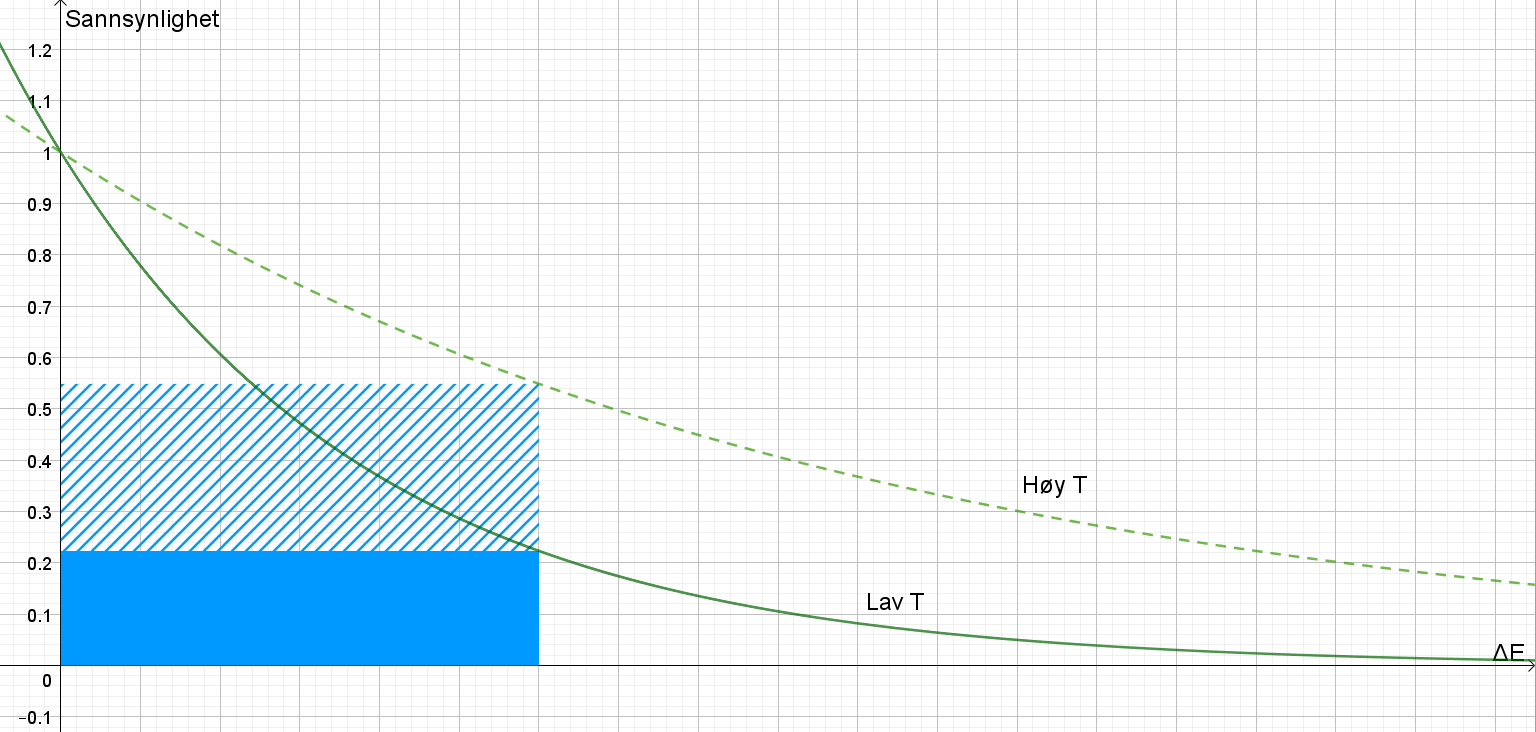
Her vil alle tall lavere enn høyden til rektangelet, føre til at bevegelsen gjennomføres, for den energien som utgjør bredden til rektangelet. Fordi vi ser at rektangelet for den høyeste temperaturen er høyere enn det andre, vil vi få flere bevegelser som skjer på grunn av statistiske hensyn snarere enn at de er energimessig foretrukket, sammenlignet med lavere temperaturer. For lavere temperaturer ser vi også gjerne en nedadgående trend i starten av prosessen, som skyldes at det vil være få bevegelser som øker energien som blir gjennomført, på grunn av denne mindre sannsynligheten. Systemet når derfor et energiminima, som det så fluktuerer rundt. For den høye temperaturen derimot, vil denne sjeldent ha klare nedadgående trender, fordi det er mer sannsynlig at energimessig ugunstige konfigurasjoner velges.  

In [7]:
Ns=50000
N = 15
M = 25
T_l = 200
T_h = 500
initial_grid = create_monomer_grid(N, M)

E_for_low_temp, monomer_grid_low_temp = Monte_Carlo(Ns, T_l, initial_grid) 
#Code to save our final grid after the simulation at T=200K 
#np.savez('grid_low_temp.npz', name1 = monomer_grid_low_temp) 
data = np.load('grid_low_temp.npz')
monomer_grid_low_temp = data['name1'] #We use a saved grid 

E_for_high_temp, monomer_grid_high_temp = Monte_Carlo(Ns, T_h, initial_grid) 

#Code to save our final grid after the simulation at T=500K
#np.savez('grid_high_temp.npz', name1 = monomer_grid_high_temp) #kommenter ut
data = np.load('grid_high_temp.npz')
monomer_grid_high_temp = data['name1'] #We use a saved grid, which we then visualize as a cluster grid later

tid=np.arange(Ns)

plt.figure(figsize=(12,6))
plt.title("MC-simulasjon, energi ved høye og lave temperaturer", loc="right")
plt.plot(tid, E_for_high_temp, label="500 K", color =  "lightsalmon")
plt.plot(tid, E_for_low_temp, label="200 K", color =  "teal")
plt.legend(loc="lower left")
plt.xlabel("MC-steg")
plt.ylabel("Energi")
plt.tight_layout()
plt.grid()
#plt.savefig('MC-simulasjon_ved_lave_og_høye_temperaturer.png')
plt.close()

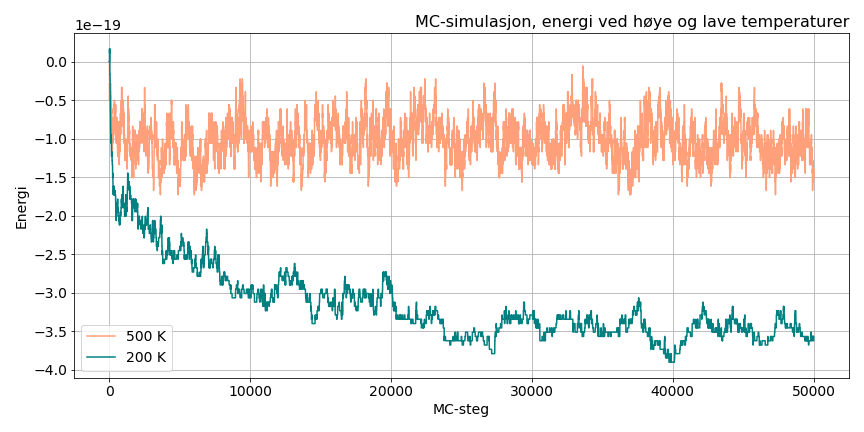

Når mennesker studerer disse konfigurasjonene er det som oftest lett å gruppere monomerene til grupper, såkalte polymerer. Datamaskinen trenger litt hjelp på veien derimot, og derfor har vi utviklet en funksjon som kan ta inn et gitter, og returnere et gitter bestående av klynger. Dette gjøres i første omgang for å gjøre monomerer til polymerer, men blir også nyttig når vi senere studerer klynger av polymerer.  

For å gjøre dette fant vi det nyttig å først definere en funksjon som returnerte koordinater for de nærmeste naboene som er monomerer. Dette viste seg dessuten å være nyttig senere, når vi ønsker å se på de nærmeste naboene som kun er løsemiddel. Vi definerer deretter en funksjon som rekursivt grupperer alle monomerer som ligger inntil hverandre til én klynge, og dette gjøres så for alle de andre klyngene til vi sitter igjen med et klynge-gitter. 

For å demonstrere funksjonen har vi visualisert det resulterende gitteret etter MC-prossesen vi kjørte tidligere, med temperatur på 200 K. Her ser vi at flere av monomerene ligger inntil monomerer med motsatt ladning, og vi får dermed negative bidrag til potensialet. Videre plotter vi også for T=500 K, og her ser vi at situasjonen er en litt annen. I dette plottet ser man at klyngene generelt er mindre, og det er også mange monomerer som mangler nære naboer, og dermed ikke bidrar til potensialet.  

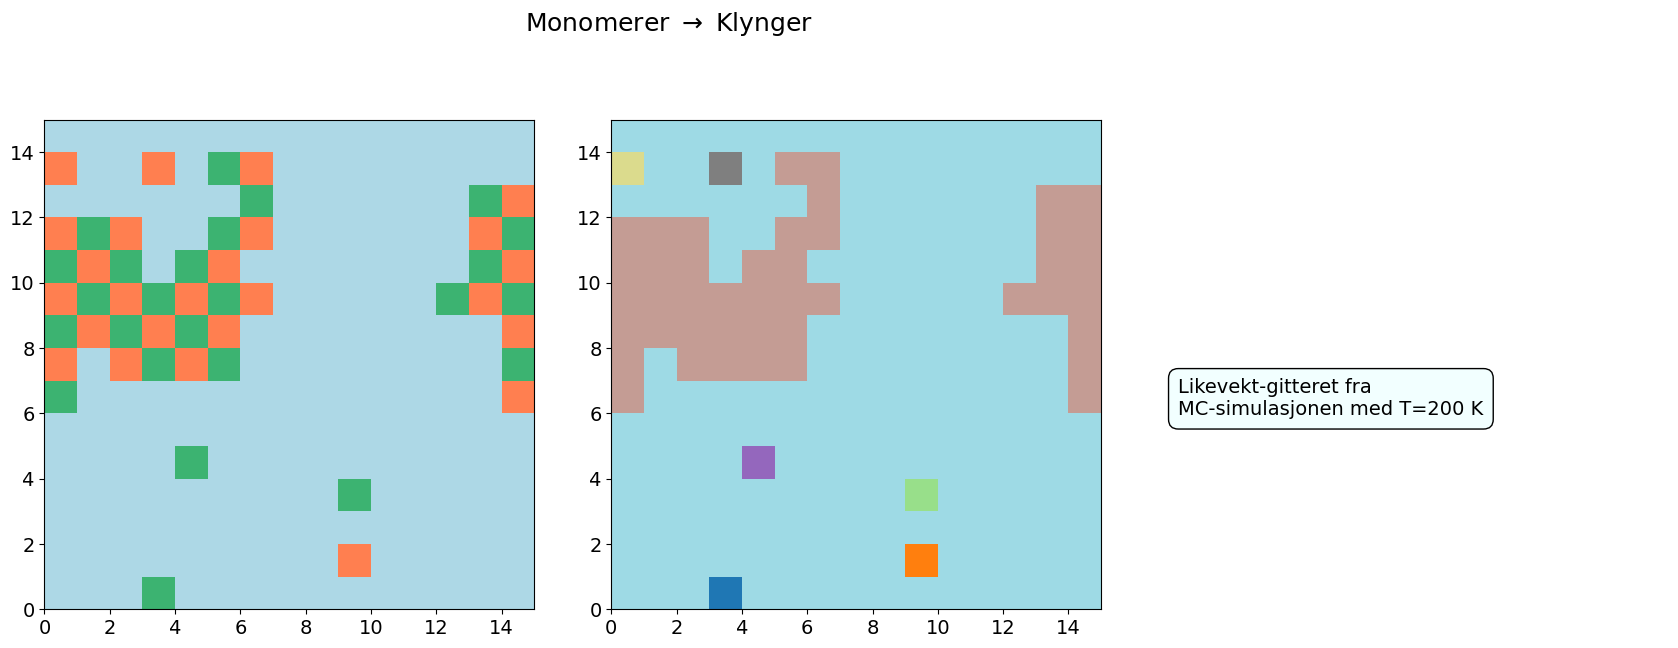

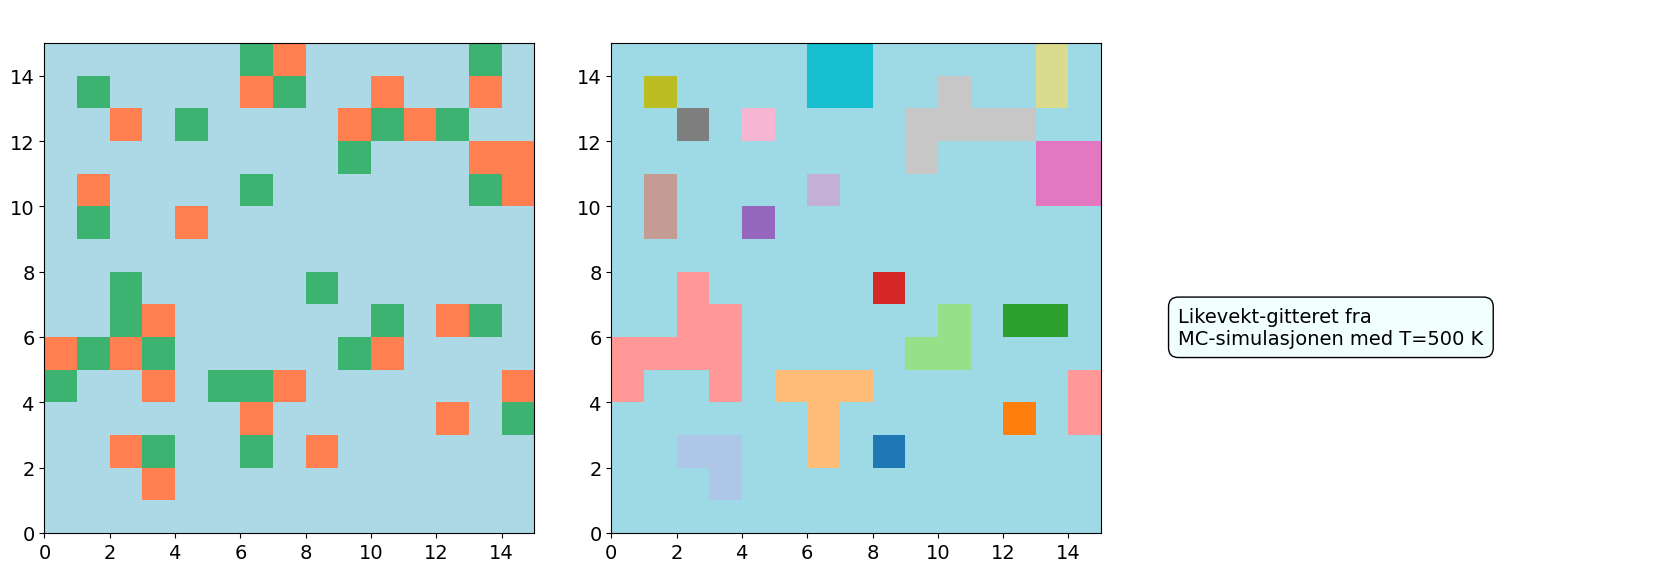

In [8]:
@jit(nopython=True)
def find_NNs_of_type(working_grid, N, i, j, kind="monomers"): #Finds all NNs that are either monomers or solvent. Defualt is set to monomers.
    NNs = nearestNeighbor(N, i, j)
    NNs_of_type = np.empty((1,2), dtype=np.dtype('i2'))
    first_iteration = True

    for i, j in NNs:
        if kind == "solvent":
            if working_grid[i][j] == 0:
                if first_iteration: #Needs to initialize array
                    NNs_of_type[0] = np.array([i,j])
                    first_iteration = False
                else: #Appends the monomer coordinate to the array
                    NN_of_type = np.array([[i,j]])
                    NNs_of_type = np.vstack((NNs_of_type, NN_of_type))
        elif kind == "monomers":
            if working_grid[i][j] != 0:
                if first_iteration: #Needs to initialize array
                    NNs_of_type[0] = np.array([i,j])
                    first_iteration = False
                else: #Appends the monomer coordinate to the array
                    NN_of_type = np.array([[i,j]])
                    NNs_of_type = np.vstack((NNs_of_type, NN_of_type))

    if first_iteration:
        return NNs_of_type, False #Returns False if the monomer has 0 NN of the type
    else:
        return NNs_of_type, True

@jit(nopython=True)
def find_monomers_in_polymer(working_grid, cluster_grid, polymer_number=1, i=0, j=0): #Adds all monomers belonging to the same polymer to the cluster grid
    N=len(working_grid)

    if i==0 and j==0: #If i and j have not been specified, we will search for the coordinate of the next monomer in the grid
        monomer = np.argwhere(working_grid)[0] #Finds first monomer that has not yet been added to a polymer
        i = monomer[0] #Coordinates of monomer
        j = monomer[1]
    
    if i == -N: #To make sure the coordinates do not go outside of the grid
        i = 0
    if j == -N:
        j = 0

    working_grid[i][j] = 0 #Erases monomer from the monomer grid
    cluster_grid[i][j] = polymer_number #Adds monomer to the cluster grid and assigns it a number unique to the polymer

    NN_monomers, has_NN_monomers = find_NNs_of_type(working_grid, N, i, j) #Finds NN monomers that have not been added to the cluster grid yet

    if has_NN_monomers:
        for k,l in NN_monomers:
            find_monomers_in_polymer(working_grid, cluster_grid, polymer_number, k, l) #Repeats process of finding monomers for the NN monomers

@jit(nopython=True)
def create_cluster_grid(monomer_grid, polymer_number=1): #Creates a cluster grid from a monomer grid
    cluster_grid = np.zeros_like(monomer_grid, dtype=np.dtype('i2'))
    working_grid = np.copy(monomer_grid) #Copies the initial monomer grid, in order to keep it unchanged

    while np.argwhere(working_grid).size > 0: #Loops until the working grid is empty and all monomers have been added to the cluster grid
        find_monomers_in_polymer(working_grid, cluster_grid, polymer_number) #Starts looking for next polymer
        polymer_number += 1

    return cluster_grid

cluster_grid_low_temp = create_cluster_grid(monomer_grid_low_temp)
cluster_grid_high_temp = create_cluster_grid(monomer_grid_high_temp)

#Plot
plt.figure(figsize=(17,6))
plt.suptitle(r"Monomerer $\rightarrow$ Klynger", x=0.4, y=1.05)
colorplot(monomer_grid_low_temp, colorbar=False)
plt.subplot(1,3,2)
plt.pcolormesh(cluster_grid_low_temp[::-1,], cmap = "tab20_r")
plt.axis("image")
plt.subplot(1,3,3)
plt.text(0, 0.4, "Likevekt-gitteret fra\nMC-simulasjonen med T=200 K", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(17,6))
colorplot(monomer_grid_high_temp, colorbar=False)
plt.subplot(1,3,2)
plt.pcolormesh(cluster_grid_high_temp[::-1,], cmap = "tab20_r")
plt.axis("image")
plt.subplot(1,3,3)
plt.text(0, 0.4, "Likevekt-gitteret fra\nMC-simulasjonen med T=500 K", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.tight_layout()
plt.show()

Det er imidlertid vanskelig å avgjøre om dette er en generell trend ut fra disse figurene alene. Vi gjennomfører derfor flere MC-simulasjoner ved forskjellige temperaturer og tilfeldig genererte startgitter. Temperaturene spenner fra 100 til 1000 K, med hopp på 100 K for hver simulasjon. I simulasjonen bruker vi først $t_{equil}$ MC-steg for at systemet skal oppnå likevekt, og gjør deretter $n$ uavhengige målinger med $t_r$ MC-steg mellom. Vi har valgt $n$ lik 50 for å få et bredt datagrunnlag, mens kjøretiden fortsatt er overkommelig.  

Målet med simulasjonene er å kunne si noe om gjennomsnittstørrelsen på klyngene, betegnet som $\bar{d}$. Denne brukes som estimator for den faktisk forventede verdien, $\langle d \rangle$. Vi mener at resultatene våre styrker vår opprinnelige ide om temperaturavhengighet, der vi får større klynger ved lavere temperaturer.  

In [9]:
@jit(nopython=True)
def find_d(N, M, T, T_l, t_r, n):
    s=1/200 #Constants used to calculate t_equil
    C=10000
    t_max=100000*2
    t_equil = int( t_max * np.exp(-s*(T-T_l)) + C)

    sum_d = 0
    initial_grid = create_monomer_grid(N, M)
    grid_at_equilibrium = Monte_Carlo(t_equil, T, initial_grid)[1]
    d_array = np.zeros((n,n))

    for i in range(n):
        polymer_grid = create_cluster_grid(grid_at_equilibrium)
        number_of_polymers = np.amax(polymer_grid)
        grid_at_equilibrium = Monte_Carlo(t_r, T, grid_at_equilibrium)[1] #Takes the grid at equalibrium as input
        d = 2*M/number_of_polymers
        sum_d += d #To calculate the average of the d values
    mean_d = sum_d/n
    polymer_grid = polymer_grid.astype(np.float64)
    return mean_d, polymer_grid, t_equil

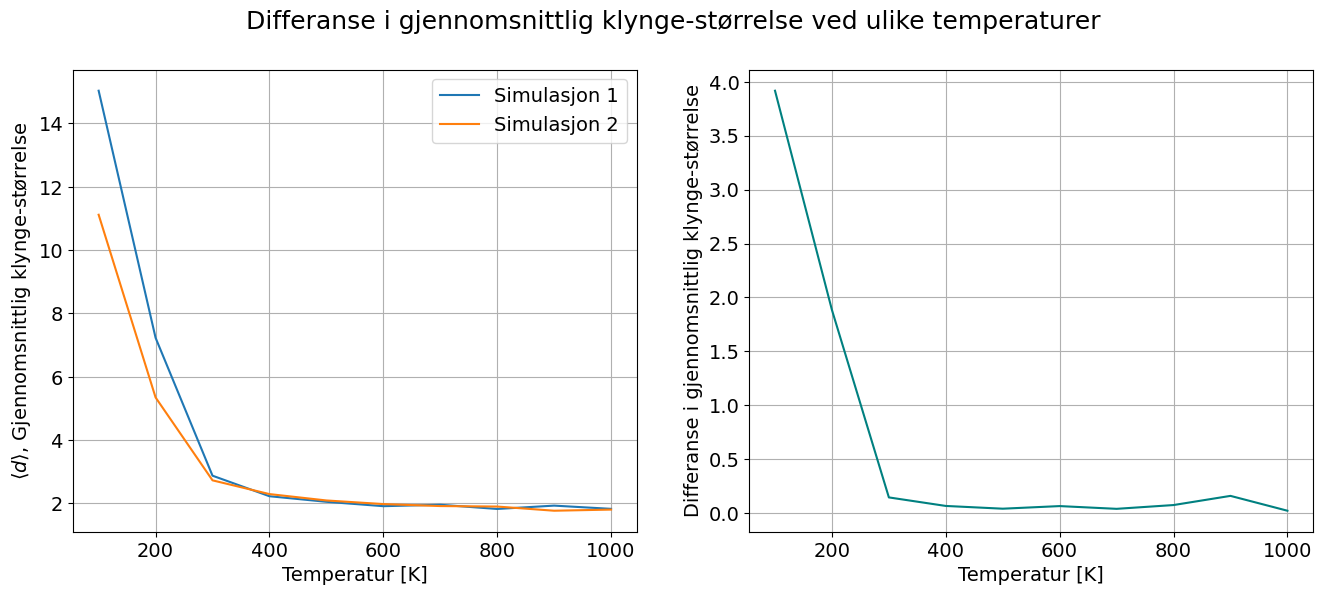

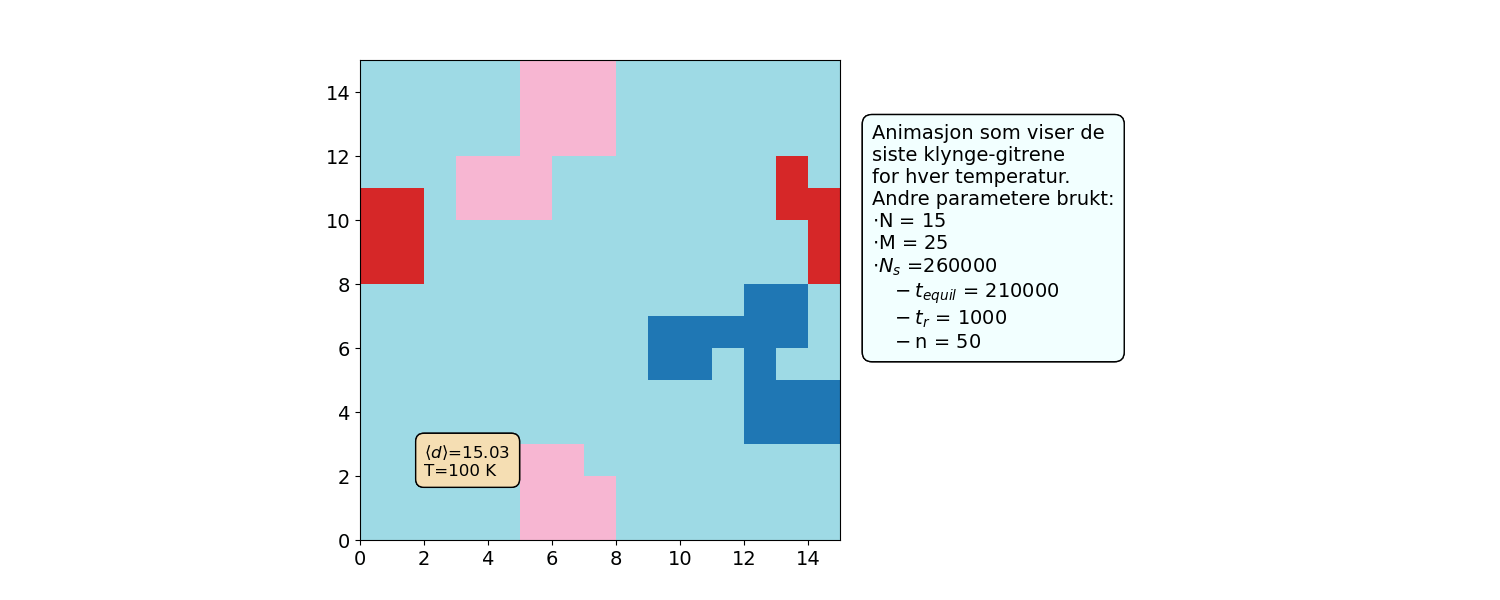

In [10]:
average_d_1 = np.array([])
average_d_2 = np.array([])
T_array = np.array([], dtype = np.dtype("i2"))
N = 15
M = 25
T_l = 100
t_r = 1000
n = 50 #Number of measurments after t_equil
N_plots = 10 #Number of plots

cluster_grids = np.zeros((N_plots,N,N))
equil_steps_array = np.array([], dtype = np.dtype("i2"))

for i in range(1, N_plots+1):
    T = 100 * i
    d_1, cluster_grid_1, t_equil_used = find_d(N, M, T, T_l, t_r, n)
    d_2, cluster_grid_2, other_t_equil = find_d(N, M, T, T_l, t_r, n)
    cluster_grids[i-1] = cluster_grid_1
    average_d_1 = np.append(average_d_1, d_1)
    average_d_2 = np.append(average_d_2, d_2)
    T_array = np.append(T_array, T)
    equil_steps_array = np.append(equil_steps_array, t_equil_used)

#Plot
plt.figure(figsize=(16,6))
plt.suptitle("Differanse i gjennomsnittlig klynge-størrelse ved ulike temperaturer")
plt.subplot(1,2,1)
plt.plot(T_array, average_d_1, label = "Simulasjon 1")
plt.plot(T_array, average_d_2, label = "Simulasjon 2")
plt.xlabel("Temperatur [K]")
plt.ylabel(r"$\langle d \rangle$, Gjennomsnittlig klynge-størrelse")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(T_array, np.abs(average_d_1-average_d_2), color = "teal")
plt.xlabel("Temperatur [K]")
plt.ylabel("Differanse i gjennomsnittlig klynge-størrelse")
plt.grid()
plt.show()

#Code to animate the final grids after the simulation at each of the temperatures
#Creates animation
fig, ax = plt.subplots(figsize=(15,6))
"""
def animate(i):
    ax.pcolormesh(cluster_grids[i][::-1,], cmap = "tab20_r" )
    ax.text(2, 2, r"$\langle d \rangle$"+f"={str(round(average_d_1[i],2)).ljust(6)}\nT={T_array[i]} K", size=12, bbox=dict(boxstyle="round, pad=0.5",fc="wheat"))
    ax.axis("image")
    ax.set_position([0,0.1,0.8,0.8])
    ax.text(16, 6, f"Animasjon som viser de\nsiste klynge-gitrene\nfor hver temperatur.\nAndre parametere brukt:\n"+
            r"$\cdot$N"+f" = {N}\n"+r"$\cdot$M "+f"= {M}\n"+r"$\cdot N_s$ =" +f"{equil_steps_array[i]+t_r*n}\n"+r"$\quad -t_{equil}$"+
            f" = {equil_steps_array[i]}\n"+r"$\quad -t_r$"+f" = {t_r}\n"+r"$\quad -$n "+f"= {n}", 
            size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
anim = animation.FuncAnimation(fig, animate, interval=1500, frames=N_plots)
anim.save('animasjon_klyngestorrelse.gif', writer='ffmpeg')
"""
#Displays animation
with open('animasjon_klyngestorrelse.gif','rb') as file:
    display(Image(file.read()))
plt.close()

Etter å ha undersøkt prosesser med monomerer, vil vi nå se på prosesser hvor vi fokuserer på klyngene monomerer danner, polymerer. For å gjøre dette følger vi mye av fremgangsmåten vi har brukt for monomerer, og starter med å lage en funksjon for å generere gitter med polymerer. Innad i hvert polymer gir vi monomerene ett visst polymer-tall, som er felles for alle monomerer i polymeret. Polymertallene spenner fra –M, til M, hvor 0 fortsatt representerer løsemiddel, så vi har totalt 2M polymerer. I likhet med monomerene svarer igjen fortegnet til om de har ladningen $–e$ eller $e$. 

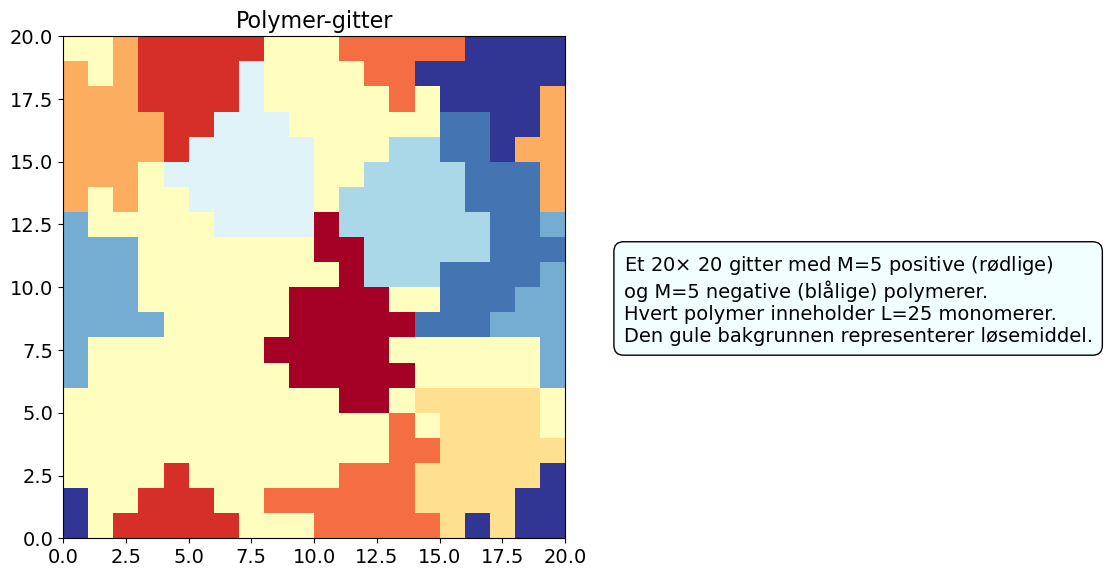

In [11]:
@jit(nopython=True)
def create_polymer_grid(L, N, M, iteration_limit = 500, function_calls = 0):
    assert 2*M*L <= N**2, "You've tried to place out more monomers than there are spaces available"
    polymer_grid = np.zeros((N, N), dtype=np.dtype('i2'))
    polymer_number = 1
    while polymer_number <= M: #Same starting point as for create_monomer_grid
        for sign in [-1, 1]: #Decides the sign of the charge
            i = rand.randint(0, N-1) #Chooses random position
            j = rand.randint(0, N-1)
            array = np.array([i, j])
            while not legal_move(array, polymer_grid):
                i = rand.randint(0, N-1)
                j = rand.randint(0, N-1)
                array = np.array([i, j])
            
            monomer_positions = np.zeros((L,2), dtype=np.dtype('i2')) 
            monomer_positions[0] = np.array([i,j])
            monomer_number = 1
            polymer_grid[i][j] = polymer_number*sign
            number_of_iterations = 0
            while monomer_number<L: #Places L connected monomers
                if number_of_iterations > iteration_limit: # If the program is struggling to place a monomer, as might be the case for some unfortunate configurations
                # we empty the grid and begin the process from scratch again. 
                    function_calls += 1
                    assert function_calls < 50, "Unfortunate configuration, the program will now start again"
                    return create_polymer_grid(L, N, M, iteration_limit, function_calls)
                number_of_iterations+=1
                random_monomer_index = rand.randint(0,monomer_number-1) #Chooses an already randomly placed monomer in the current polymer
                random_monomer_coordinate = monomer_positions[random_monomer_index]
                k = random_monomer_coordinate[0]
                l = random_monomer_coordinate[1]
                NN_solvent, has_NN_solvent = find_NNs_of_type(polymer_grid, N, k, l, "solvent") #Determines if there are any vacant spots next to said monomer
                if has_NN_solvent: #Chooses one of these vacant spots randomly, and makes this part of our polymer
                    random_index = rand.randint(0, len(NN_solvent)-1)
                    random_monomer = NN_solvent[random_index]
                    monomer_positions[monomer_number] = random_monomer
                    polymer_grid[random_monomer[0]][random_monomer[1]] = polymer_number*sign
                    monomer_number += 1

        polymer_number +=1
    return polymer_grid

L=25
N=20
M=5
polymer_grid = create_polymer_grid(L, N, M)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Polymer-gitter")
plt.pcolormesh(polymer_grid[::-1,], cmap = "RdYlBu_r" )
plt.axis('image')
plt.subplot(1,2,2)
plt.text(0.05, 0.4, f"Et {N}" r"$\times$"+f" {N} gitter med M={M} positive (rødlige)\nog M={M} negative (blålige) polymerer.\nHvert polymer inneholder L={L} monomerer.\nDen gule bakgrunnen representerer løsemiddel.", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis('off')
plt.tight_layout()
plt.show()

Når vi nå er interesserte i energien til systemer av polymerer, er dette egentlig bare en utvidelse av situasjonen for monomere. Den eneste forskjellen er at vi nå også ser bort fra elektriske interaksjoner innad i polymeret. Hadde vi gjort dette kunne vi for eksempel funnet hvilke formasjoner av monomerer innad i et polymer som er energimessig gunstige, men vi er nå mest interessert i interaksjonen mellom forskjellige polymerer. 

In [12]:
@jit(nopython=True)
def potential_for_polymersystem(polymer_grid):
    epsilon_r = 78 # The permittivitity of the solution
    a = 91E-6 # Distance between nearest neighbors
    epsilon_zero = 8.85E-12 # The permittivity of vacuum
    e = 1.6E-19 #Elementary charge
    alpha = e**2/(4*np.pi*epsilon_zero*epsilon_r*a**2)
    polymer_coordinates = np.argwhere(polymer_grid)  #Makes an array with the coordinates of the monomers
    N = len(polymer_grid)
    total_potential = 0
    for i, j in polymer_coordinates: # Where i and j represent the coordinates of the monomer
        NN_list = nearestNeighbor(N, i, j) #Makes an array with the positions of the NN for one non_zero element 
        for k, l in NN_list: # Coordinates of the NNs
            if polymer_grid[k][l] != 0 and polymer_grid[k][l] != polymer_grid[i][j]: #Different from for monomersystem, we also now have to ignore the electrical interactions within
            # a polymer
                total_potential += np.sign(polymer_grid[i][j]) * np.sign(polymer_grid[k][l]) * alpha #Formula for the potential, with the sign() function used to only look at the signs, so that the
                #polymer number doesn't affect the value of the potential
    total_potential = total_potential / 2 #Accounts for counting the interactions between NNs twice
    return total_potential

I utgangspunktet kan også bevegelse av polymerer være ganske likt monomerers bevegelse. Vi kan for eksempel bare tillate polymeret å bevege seg ett steg i ei retning, og at alle monomerene da flytter seg i den angitte retninga. Dette kaller vi for en stiv bevegelse. I implementeringa av koden for å gjøre dette kom vi også på en nyttig idé som vi også får bruk for senere. Denne er at man istedenfor å gi maskinen eksplisitte kommandoer for å flytte polymeret i de forskjellige retningene (høyre, venstre, opp og ned), bare gir kommandoer for å flytte til høyre. Dermed kan man senere ved hjelp av matriseoperasjoner, som å transponere, manipulere gridet slik at man får de ønskede bevegelsene.  

Vi beholder også reglene for hva som er en gyldig bevegelse, polymerene våre kan altså ikke fortrenge andre polymerer. Med disse verktøyene på plass i verktøykassa er vi nå klare for å gjøre en MC-simulasjon med polymerer.  

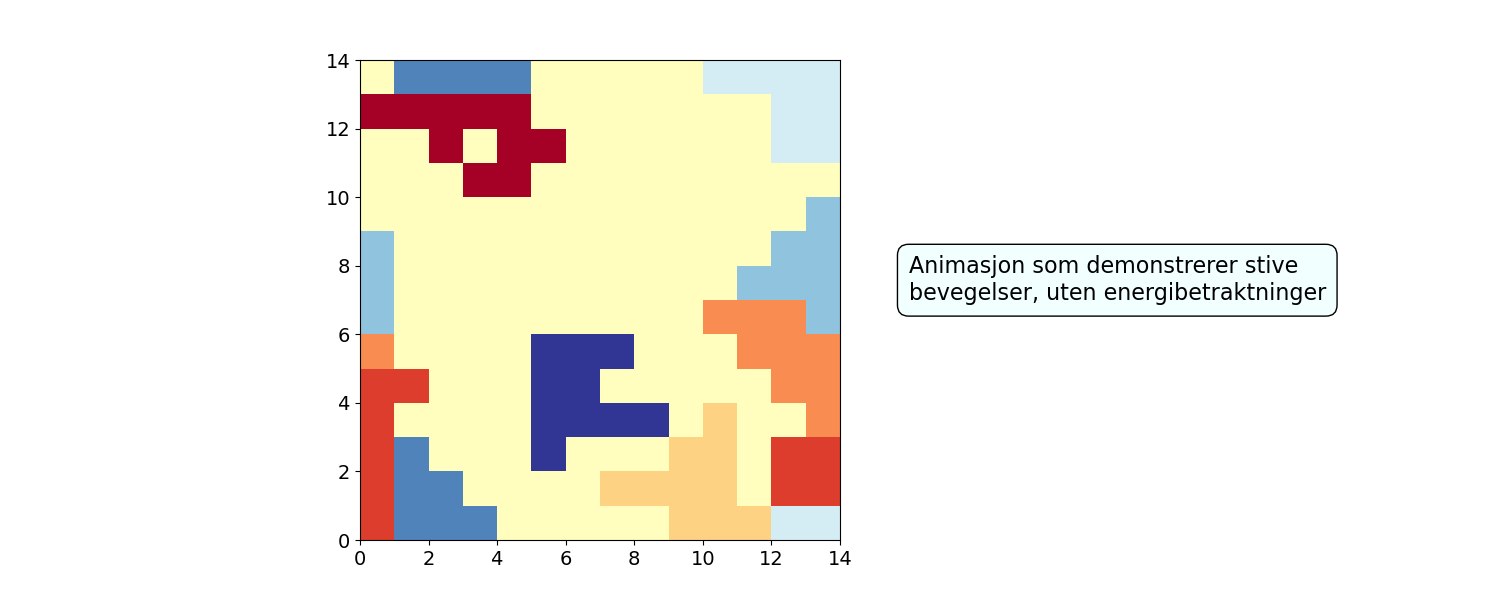

In [23]:
@jit(nopython=True)
def rigid_move_to_the_right(polymer_grid, polymer_number, direction):
    N = len(polymer_grid) 
    movement_grid = polymer_grid.copy()
    y, x = np.where(polymer_grid == polymer_number)    #We get an array on the form (([y_1, y_2, ...]), ([x_1, x_2, ...])), where [y_1, x_1] are the coordinates of a point
    #in our grid that has the value polymer_number
    # We now make an array on the form ([y_1, x_1, y_2, x_2, ....]), called polymer_list, that is, an array of the coordinates of all monomers belonging to the polymer of a certain
    # polymer number
    polymer_list = np.zeros((len(x), 2), dtype = np.dtype('i2'))
    for i in range(0, len(x)):
        polymer_list[i]= np.array([y[i], x[i]]) 
    for i, j in polymer_list: #We iterate through the monomers of our polymer
            if polymer_grid[i][j-1] != polymer_number: #If our monomer doesn't have a monomer neighbor belonging to the same polymer in the oppposite direction of the movement,
            # we move the monomer, and fill its original position with solvent. This is a general condition that is applied in all of the directions. 
                if j == N-1:
                    j=-1
                movement_grid[i][j+1] = polymer_number
                movement_grid[i][j] = 0
            else: #If it has a neighbor in the opposite direction of movement, we move the monomer, but do not erase the original position, as its neighbor will fill it when it moves.
                if j == N-1:
                    j=-1
                movement_grid[i][j+1]=polymer_number

    original_number_of_monomers = len(np.argwhere(polymer_grid))
    new_number_of_monomers = len(np.argwhere(movement_grid))
    if new_number_of_monomers < original_number_of_monomers:
        return polymer_grid
    else:
        return movement_grid
    

@jit(nopython=True)
def rigid_move(polymer_grid, polymer_number, direction):
    if direction == 0: #Attempted movement to the right
        moved_grid = rigid_move_to_the_right(polymer_grid, polymer_number, direction)
    if direction == 1: #Left
        flipped_initial_grid = np.fliplr(polymer_grid)
        flipped_moved_grid = rigid_move_to_the_right(flipped_initial_grid, polymer_number, direction)
        moved_grid = np.fliplr(flipped_moved_grid)
    if direction == 2: #Up 
        rotated_initial_grid = np.transpose(np.flipud(polymer_grid)) #Rotates grid 90 degrees clockwise
        rotated_moved_grid = rigid_move_to_the_right(rotated_initial_grid, polymer_number, direction)
        moved_grid = np.flipud(np.transpose(rotated_moved_grid)) #Rotates grid 90 degrees anti-clockwise
    if direction == 3: #down
        rotated_initial_grid = np.flipud(np.transpose(polymer_grid)) #Rotates grid 90 degrees anti-clockwise
        rotated_moved_grid = rigid_move_to_the_right(rotated_initial_grid, polymer_number, direction)
        moved_grid = np.transpose(np.flipud(rotated_moved_grid)) #Rotates grid 90 degrees clockwise
    return moved_grid

N_grids = 30 #number of grids (frames) in animation
N = 14
M = 4
L = 10

polymer_grids = np.zeros((N_grids, N, N))
polymer_grid = create_polymer_grid(L, N, M)

for i in range(N_grids):
    polymer_grids[i] = polymer_grid

    random_polymer_number = rand.randint(-M, M) #picks a random polymer to move
    while random_polymer_number == 0:
        random_polymer_number = rand.randint(-M, M)

    random_direction = rand.randint(0,3) #picks a random direction
    polymer_grid = rigid_move(polymer_grid, random_polymer_number, random_direction)

#Creates animation
fig, ax = plt.subplots(figsize=(15,6))
"""
def animate(i):
    ax.pcolormesh(polymer_grids[i][::-1,], cmap = "RdYlBu_r")
    ax.axis("image")
    ax.set_position([0,0.1,0.8,0.8])
anim = animation.FuncAnimation(fig, animate, interval=300, frames=N_grids)
ax.text(16, 7, "Animasjon som demonstrerer stive\nbevegelser, uten energibetraktninger", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
anim.save('animasjon_stive_bevegelser.gif', writer='ffmpeg')
"""
#Displays animation
with open('animasjon_stive_bevegelser.gif','rb') as file:
    display(Image(file.read()))
plt.close()

Vi kjører nå en MC-simulasjon med et $20 \times 20$-gitter, med M=4 polymerer, som hver inneholder L=15 monomerer. Som vi ser av figuren under, er det ingen endringer i form for polymerene, slik det også skal være ved stive bevegelser. Ellers virker konfigurasjonene relativt tilfeldige, og dette kan ha noe med å gjøre at vi nå flytter større bestanddeler. Da blir simulasjonene i mye større grad avhengig av delenes former, og at de kan passe med hverandre som biter i et puslespill. Dette er i motsetning til monomerer, som faktisk kan gå sammen for å danne puslespillbitene som trengs. Dermed vil vi gjerne også trenge færre steg, fordi det for hvert steg gjerne er mindre mulighet for å få minket energien, sammenlignet med monomerene. 

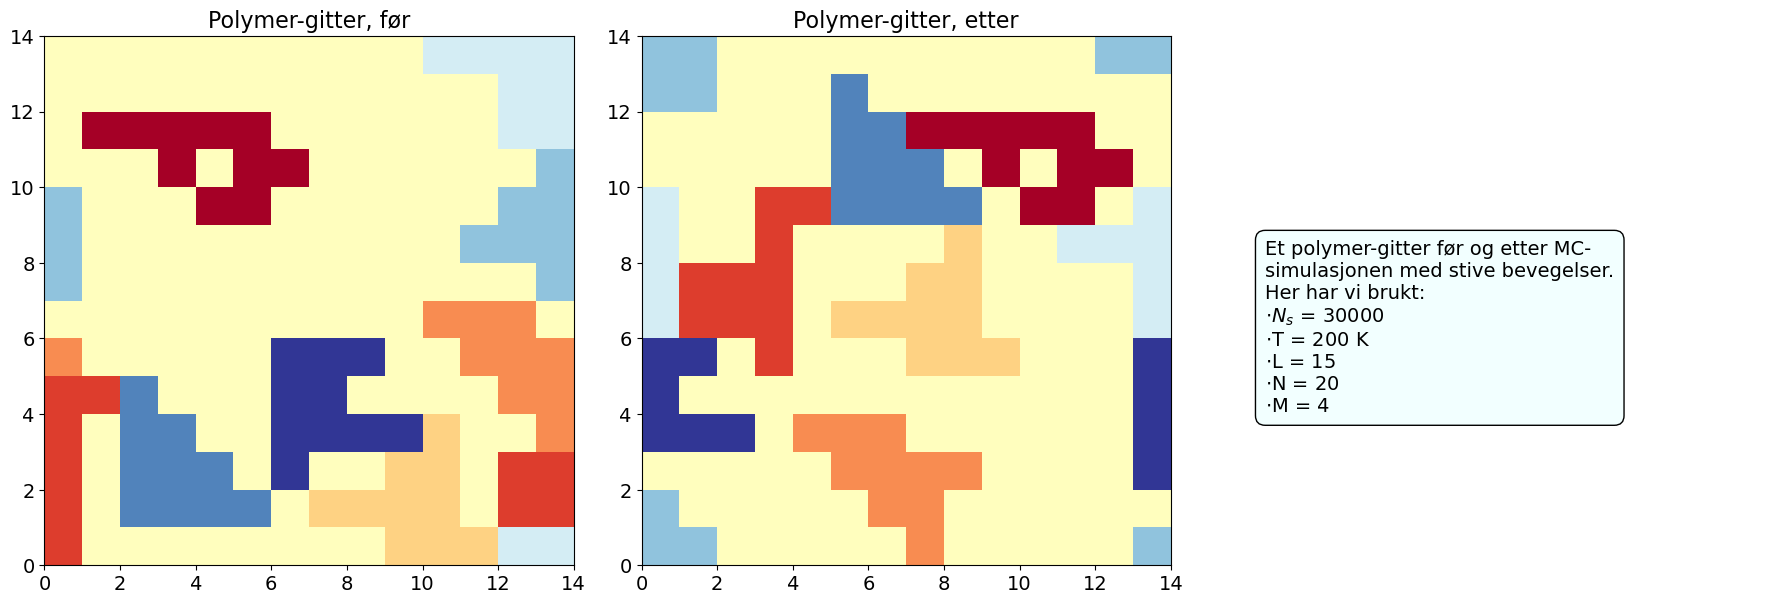

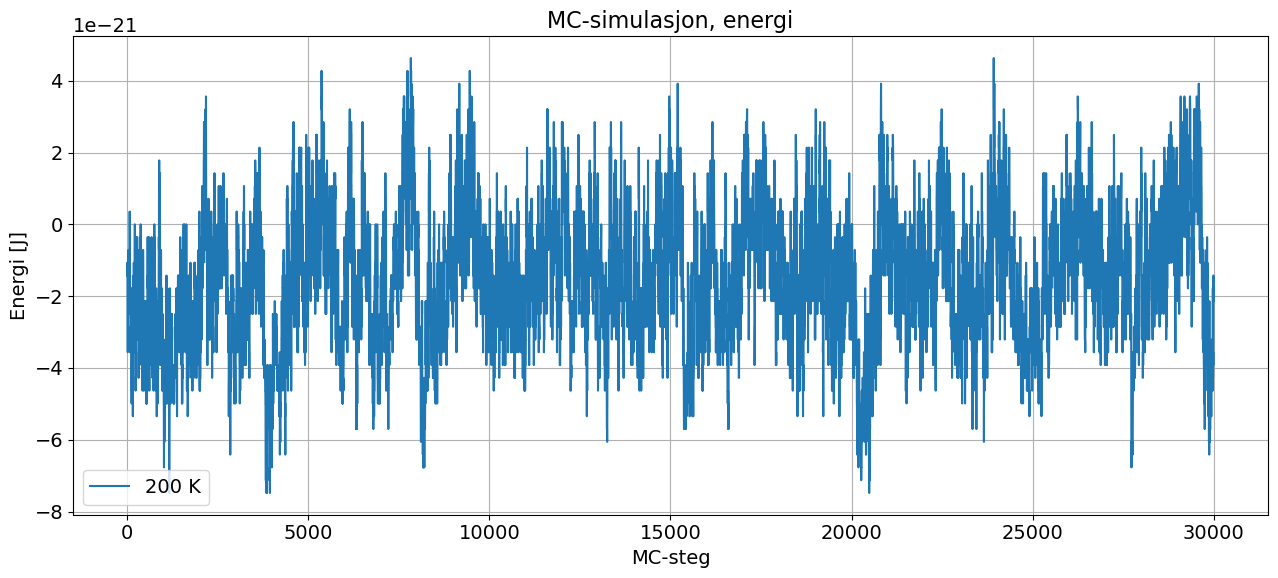

In [14]:
"""For our next MC-simulation, we reuse the framework of our original Monte-Carlo-function, and also implement the option of having rigid moves of polymers."""

@jit(nopython=True)
def Monte_Carlo_expanded(N_s, T, initial_grid, choice_of_move="rigid_move"):
    Beta = 1/(Kb*T)
    epsilon = np.zeros(N_s, dtype=np.float64) #Initializes the energy-array

    if choice_of_move == "monomer_move":
        epsilon, initial_grid = Monte_Carlo(N_s, T, initial_grid)

    elif choice_of_move == "rigid_move":
        E = potential_for_polymersystem(initial_grid) #Initial energy
        M = np.amax(initial_grid)
        epsilon[0] = E
        for i in range(N_s):
            E = potential_for_polymersystem(initial_grid)
            random_polymer_number = rand.randint(-M, M)
            while random_polymer_number == 0:
                random_polymer_number = rand.randint(-M, M)
            random_direction = rand.randint(0, 3)
            grid_candidate = rigid_move(initial_grid, random_polymer_number, random_direction)
            if not np.array_equal(grid_candidate, initial_grid):
                E_new = potential_for_polymersystem(grid_candidate)
                if E_new < E:
                    initial_grid = grid_candidate
                    E = E_new
                else:
                    prob = np.exp(-Beta *(E_new - E))
                    if rand.random() < prob:
                        initial_grid = grid_candidate
                        E = E_new 
            epsilon[i] = E
    return epsilon, initial_grid

N_s = 30000
T = 200
L = 15
N = 20
M = 4

polymer_grid_2d = create_polymer_grid(L, N, M)

#Plot
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title("Polymer-gitter, før")
plt.pcolormesh(polymer_grid[::-1,], cmap = "RdYlBu_r" )
plt.axis("image")

energy_2d, MC_grid_2d = Monte_Carlo_expanded(N_s, T, polymer_grid, "rigid_move")

plt.subplot(1,3,2)
plt.title("Polymer-gitter, etter")
plt.pcolormesh(MC_grid_2d[::-1,], cmap = "RdYlBu_r" )
plt.axis("image")

plt.subplot(1,3,3)
plt.text(0.05,0.3, "Et polymer-gitter før og etter MC-\nsimulasjonen med stive bevegelser.\nHer har vi brukt:\n" +r"$\cdot N_s$ = " + f"{N_s}\n"+
         r"$\cdot$T = "+f"{T} K\n"+r"$\cdot$L = "+f"{L}\n"+r"$\cdot$N = "+f"{N}\n"+r"$\cdot$M = "+f"{M}", 
         size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis('off')
plt.tight_layout()
plt.show()

tid=np.arange(N_s)

plt.figure(figsize=(13, 6))
plt.title("MC-simulasjon, energi")
plt.plot(tid, energy_2d, label="200 K")
plt.legend(loc="lower left")
plt.xlabel("MC-steg")
plt.ylabel("Energi [J]")
plt.tight_layout()
plt.grid()
plt.show()

I realiteten vil polymerer også kunne endre form. For å implementere denne bevegelsen, en såkalt halvfleksibel bevegelse, bruker vi grunntanken om matrisemanipulasjon fra koden for stive bevegelser. Selve bevegelsen til høyre vil da bestå i at man ser på horisontale rader i polymeret, og radene beveger seg stivt uavhengig av hverandre. Dersom det skulle være en rad hvor ikke alle monomerene i polymeret kan gjøre en stiv bevegelse, låses raden.  

Dette introduserer et nytt problem, nemlig at polymerer kan bli splittet i flere deler. Vi begynner derfor med å lage en funksjon som sjekker om polymeret fortsatt henger sammen etter en bevegelse. Her gjenbruker vi tidligere funksjoner, og ideen er at vi lager ett nytt gitter med bare løsemiddel og polymeret vi er interessert i etter en gjennomført bevegelse. Deretter sjekker vi antall klynger i dette systemet, og om antallet er større enn én, har vi fått et ødelagt polymer.  


I tillegg vil prosessen nå være styrt av tilfeldighetene i mindre grad enn tidligere, ettersom vi nå vil kunne få større kontaktoverflater mellom polymerene, og med det størrre energibidrag. Vi forventer da å se at polymerene lettere bindes sammen, og at systemet faktisk når et energiminima. 

In [15]:
@jit(nopython=True)
def check_if_polymer_is_broken(moved_grid, polymer_number):
    working_grid = moved_grid.copy()
    working_grid = np.where(working_grid == polymer_number, working_grid, working_grid*0)    
    #We get an array on the form (([y_1, y_2, ...]), ([x_1, x_2, ...])), where [y_1, x_1] are the coordinates of a point
    """Det over stemmer ikke helt for denne oppgaven, vi får ut et grid med 0 utenom der working_grid == polymer_number"""
    cluster_grid = create_cluster_grid(working_grid)
    greatest_polymer_number = np.amax(cluster_grid)
    if greatest_polymer_number > 1:
        return True
    else:
        return False

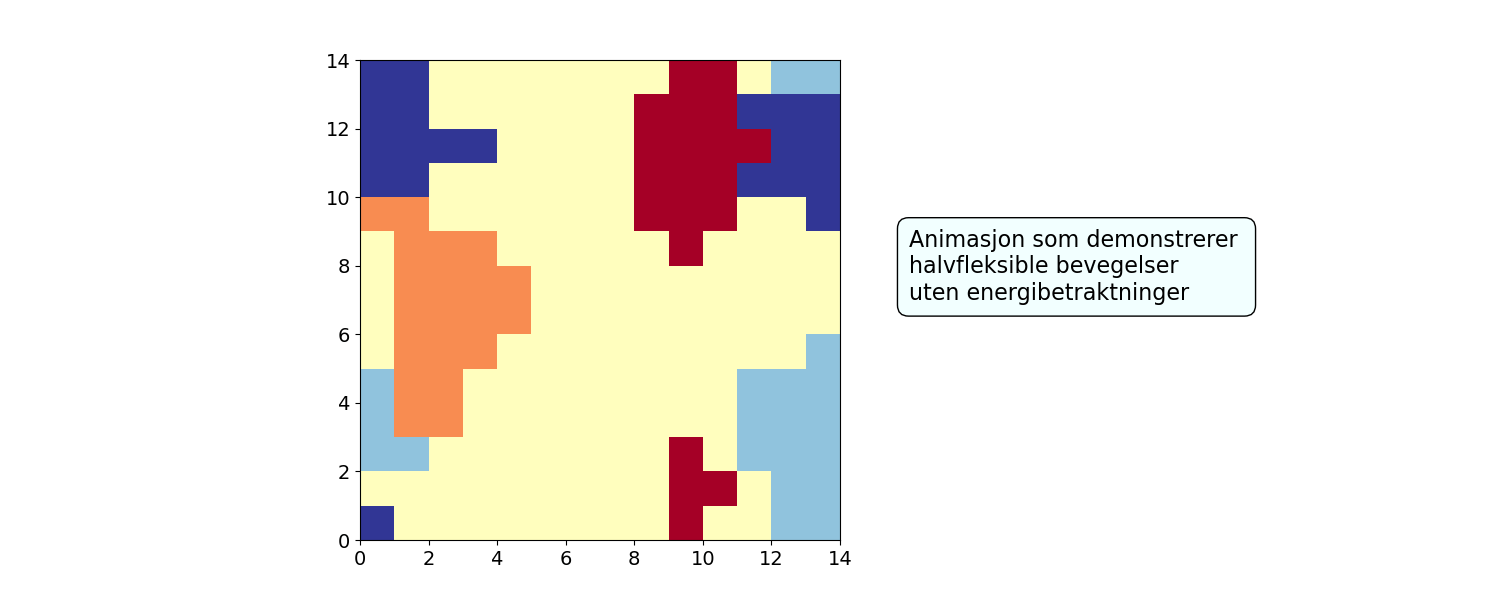

In [20]:
@jit(nopython=True)
def medium_flexibility_move_to_the_right(polymer_grid, polymer_number, direction):
    N = len(polymer_grid) 
    movement_grid = polymer_grid.copy()
    y, x = np.where(polymer_grid == polymer_number)    #We get an array on the form (([y_1, y_2, ...]), ([x_1, x_2, ...])), where [y_1, x_1] are the coordinates of a point
    #in our grid that has the value polymer_number
    # We now make an array on the form ([y_1, x_1, y_2, x_2, ....]), called polymer_list, that is, an array of the coordinates of all monomers belonging to the polymer of a certain
    # polymer number
    polymer_list = np.zeros((len(x), 2), dtype = np.dtype('i2'))
    for i in range(0, len(x)):
        polymer_list[i]= np.array([y[i], x[i]])
    y = np.unique(y) #Makes sure that we only iterate over every row once
    for i in y:
        while True:
            row = movement_grid[i]
            working_row = row.copy() #We make a copy of our row, because we later need to modify this row, but we still have to have our original row to compare to, and fall back to
            # in case of an illegal move
            for j in range(N): #We iterate through the elements of our row
                if j == N-1:
                    j=-1
                if row[j] == polymer_number: #Chooses the monomers belonging to our polymer of our row
                    if row[j+1] == polymer_number or row[j+1]==0: #To check if the monomer will collide with a monomer belonging to a different polymer
                        if row[j-1] != polymer_number: #If we dont have a monomer of the same polymer as a NN to the left, we move the monomer to the right and fill the void with solvent
                            working_row[j+1] = polymer_number
                            working_row[j] = 0

                        else: #Here we do not fill the vacant spot with solvent, as another monomer of the same polymer will have/will fill the gap
                            working_row[j+1]=polymer_number
                    else:  #The monomer will collide, so this is an illegal move, and we proceed with our original row
                        working_row = movement_grid[i] 
                        break
            break
        movement_grid[i] = working_row
    return movement_grid


@jit(nopython=True)
def medium_flexibility_move(polymer_grid, polymer_number, direction):

    if direction == 0: #Right
        moved_grid = medium_flexibility_move_to_the_right(polymer_grid, polymer_number, direction)

    if direction == 1: #Left
        flipped_initial_grid = np.fliplr(polymer_grid)
        flipped_moved_grid = medium_flexibility_move_to_the_right(flipped_initial_grid, polymer_number, direction)
        moved_grid = np.fliplr(flipped_moved_grid)
    
    if direction == 2: #Up 
        rotated_initial_grid = np.transpose(np.flipud(polymer_grid)) #Rotates grid 90 degrees clockwise
        rotated_moved_grid = medium_flexibility_move_to_the_right(rotated_initial_grid, polymer_number, direction)
        moved_grid = np.flipud(np.transpose(rotated_moved_grid)) #Rotates grid 90 degrees anti-clockwise
    
    if direction == 3: #down
        rotated_initial_grid = np.flipud(np.transpose(polymer_grid)) #Rotates grid 90 degrees anti-clockwise
        rotated_moved_grid = medium_flexibility_move_to_the_right(rotated_initial_grid, polymer_number, direction)
        moved_grid = np.transpose(np.flipud(rotated_moved_grid)) #Rotates grid 90 degrees clockwise
    
    if check_if_polymer_is_broken(moved_grid, polymer_number):
        return polymer_grid
    else:
        return moved_grid

N_grids = 30 #number of grids (frames) in animation
N = 14
M = 2
L = 20

polymer_grids = np.zeros((N_grids, N, N))
polymer_grid = create_polymer_grid(L, N, M)


for i in range(N_grids):
    polymer_grids[i] = polymer_grid

    random_polymer_number = rand.randint(-M, M) #picks a random polymer to move
    while random_polymer_number == 0:
        random_polymer_number = rand.randint(-M, M)

    random_direction = rand.randint(0,3) #picks a random direction
    polymer_grid = medium_flexibility_move(polymer_grid, random_polymer_number, random_direction)

#Creates animation
fig, ax = plt.subplots(figsize=(15,6))
"""
def animate(i):
    ax.pcolormesh(polymer_grids[i][::-1,], cmap = "RdYlBu_r")
    ax.axis("image")
    ax.set_position([0,0.1,0.8,0.8])
anim = animation.FuncAnimation(fig, animate, interval=300, frames=N_grids)
ax.text(16, 7, "Animasjon som demonstrerer \nhalvfleksible bevegelser \nuten energibetraktninger", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
anim.save('animasjon_halvfleksible_bevegelser.gif', writer='ffmpeg')
"""
#Displays animation
with open('animasjon_halvfleksible_bevegelser.gif','rb') as file:
    display(Image(file.read()))
plt.close()

For å undersøke om vi får lavere energier og sammenfletting ved halvfleksible bevegelser, gjør vi en ny MC-prosess. Denne prosessen har samme parametere og utgangspunkt som den med stive bevegelser, da det er forskjellen i type bevegelse som interesserer oss. Ved å sammenligne slutt-gitterne fra prossesene, ser vi betydelige forskjeller. Denne forskjellen kan sammenlignes med forskjellen mellom kokt og ukokt spaghetti. Mens den harde, ukokte spaghettien ikke endrer form eller sammenflettes, vil et fat med kokt spaghetti gjerne bestå av sammenhengende, komplekse strukturer. På samme måte er gitteret etter stive bevegelser ganske tilfeldig konfigurert, med stive deler litt rundt omkring, mens med halvfleksible bevegelser har polymerene flettet seg sammen.  

Det er etter den halvfleksible simulasjonen at vi observerer de laveste energiene. Dette samsvarer også godt med det vi kan tolke fra gitteret, hvor vi ser at det er mange kontaktpunkter mellom polymerer med negativ ladning (blålige) og de med positiv ladning (rødlige). Det er disse kontaktpunktene som utgjør energibidragene, og kontaktpunkter mellom ulikt ladde polymerer er ønskelige, da de gir negative bidrag.  

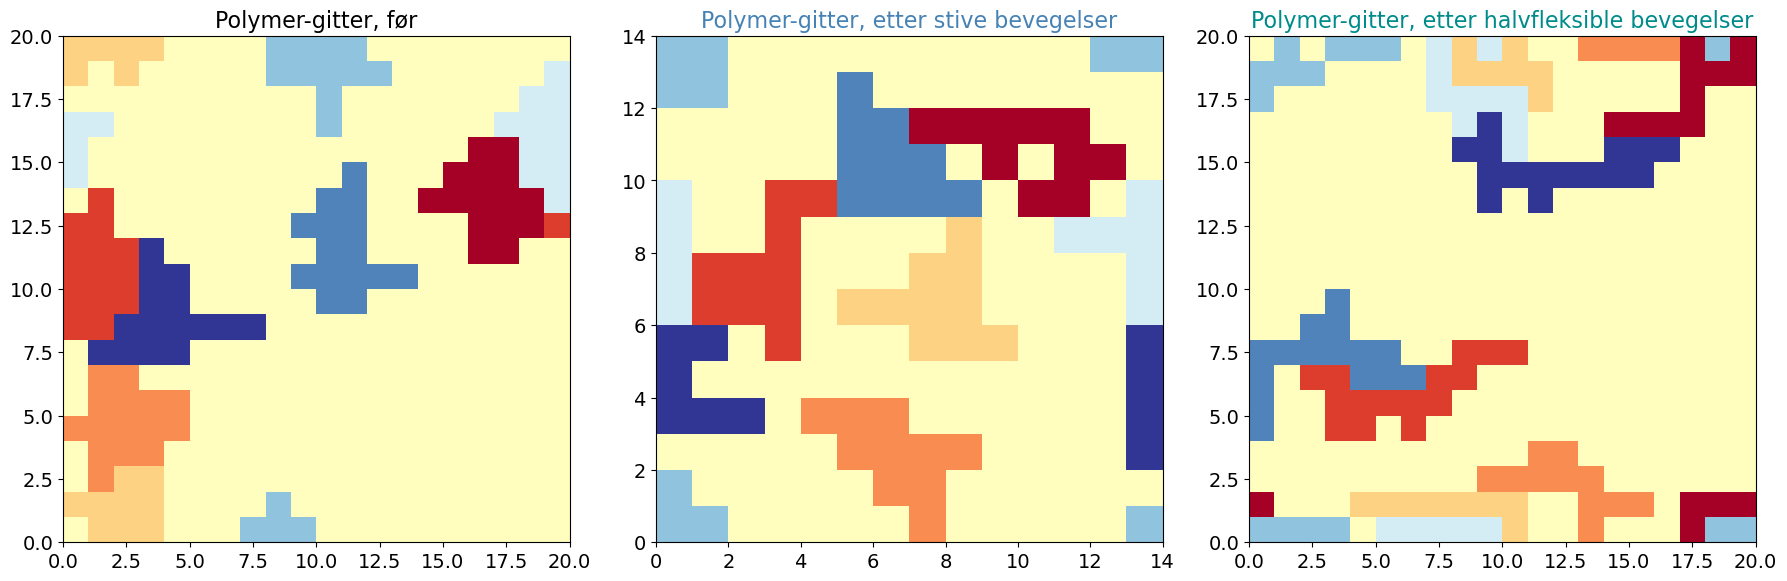

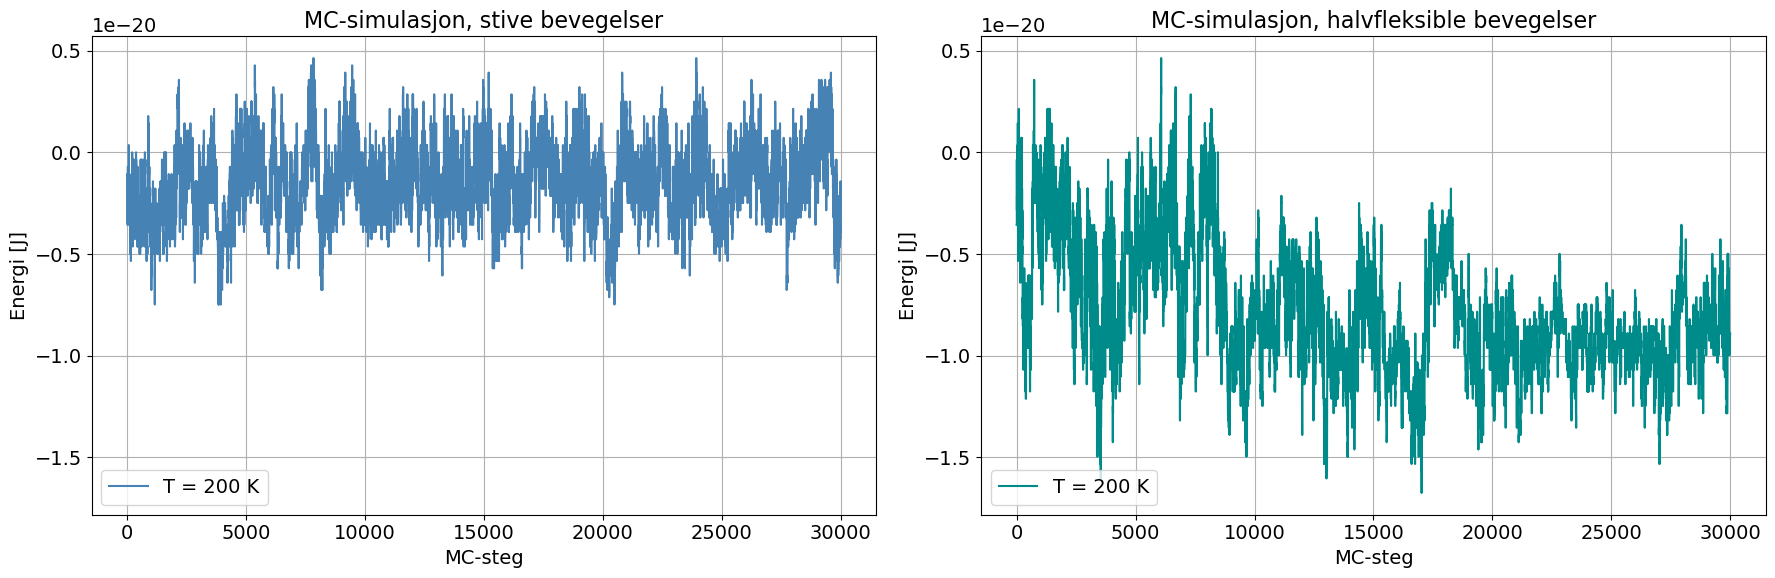

In [21]:
"""For our next MC-simulation, we reuse the framework of our previous Monte-Carlo-function, and also implement the option of having medium-flexibility moves of polymers."""

@jit(nopython=True)
def Monte_Carlo_final(N_s, T, initial_grid, choice_of_move = "medium_flexibility"):
    Beta = 1/(Kb*T)
    epsilon = np.zeros(N_s, dtype=np.float64) #Initializes the energy-array

    if choice_of_move == "medium_flexibility":
        E = potential_for_polymersystem(initial_grid) #Initial energy
        M = np.amax(initial_grid)
        epsilon[0] = E
        for i in range(N_s):
            E = potential_for_polymersystem(initial_grid)
            random_polymer_number = rand.randint(-M, M)
            while random_polymer_number == 0:
                random_polymer_number = rand.randint(-M, M)
            random_direction = rand.randint(0, 3)
            grid_candidate = medium_flexibility_move(initial_grid, random_polymer_number, random_direction)
            if not np.array_equal(grid_candidate, initial_grid):
                E_new = potential_for_polymersystem(grid_candidate)
                if E_new < E:
                    initial_grid = grid_candidate
                    E = E_new
                else:
                    prob = np.exp(-Beta *(E_new - E))
                    if rand.random() < prob:
                        initial_grid = grid_candidate
                        E = E_new 
            epsilon[i] = E
    else:
        epsilon, initial_grid = Monte_Carlo_expanded(N_s, T, initial_grid, choice_of_move)
    return epsilon, initial_grid

N_s = 30000
T = 200

#Plot
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title("Polymer-gitter, før")
plt.pcolormesh(polymer_grid_2d[::-1,], cmap = "RdYlBu_r" )
plt.axis("image")

plt.subplot(1,3,2)
plt.title("Polymer-gitter, etter stive bevegelser", color="steelblue")
plt.pcolormesh(MC_grid_2d[::-1,], cmap = "RdYlBu_r" )
plt.axis("image")

energy2, MC_grid_medium_flexibility = Monte_Carlo_final(N_s, T, polymer_grid_2d, "medium_flexibility")

plt.subplot(1,3,3)
plt.title("Polymer-gitter, etter halvfleksible bevegelser", color="darkcyan")
plt.pcolormesh(MC_grid_medium_flexibility[::-1,], cmap = "RdYlBu_r" )
plt.axis("image")
plt.tight_layout()
plt.show()

tid=np.arange(N_s)

plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
plt.title("MC-simulasjon, stive bevegelser")
plt.plot(tid, energy_2d, label="T = 200 K", color="steelblue")
plt.legend(loc="lower left")
plt.xlabel("MC-steg")
plt.ylabel("Energi [J]")
plt.grid()

ax2 = plt.subplot(1,2,2, sharey=ax1)
plt.title("MC-simulasjon, halvfleksible bevegelser")
plt.plot(tid, energy2, label="T = 200 K", color="darkcyan")
plt.legend(loc="lower left")
plt.xlabel("MC-steg")
plt.ylabel("Energi [J]")
plt.tight_layout()
plt.grid()
plt.show()

Som vi nå har sett med halvfleksible bevegelser, tenderer polymerer med motsatt ladning til å samle seg i klynger, dersom de gis muligheten til å endre form. Disse klyngene er av direkte praktisk betydning, da det er de som utgjør organellene vi er interesserte i. Spesielt interessert er vi i størrelsene ${\langle d\rangle}/{L}$, som er gjennomsnittlig antall polymerer som utgjør en klynge, og $m$, antall klynger.  

For å få innsikt i hvordan disse størrelsene varierer, som funksjon av L, kjører vi nå en ny MC-prosess, med 13 L-verdier mellom 3 og 39. For å bestemme antall MC-steg før systemet oppnår likevekt, tar vi utgangspunkt i energiplottet fra MC-prosessen vi tidligere kjørte med halvfleksible bevegelser. Dette vil variere fra simulasjon til simulasjon, men kan gi et inntrykk av størrelsesordenen til $t_{equil}$. Det skal riktignok også sies at det kan være vanskelig å se en tydelig likevekts-trend, men vi har valgt å overestimere litt, og sette den til 30 000. Videre har vi valgt å gjennomføre n=25 målinger etter likevekt, en halvering av antall målinger fra simulasjonene for monomerer. Dette kan begrunnes med at vi for polymerer ser at størrelsesordene på energisvingningene her er betraktelig mindre (omtrent en faktor på 10) enn for monomerer. 

Av plottene ser vi at størrelsene vi jobber med er omvendt proporsjonale. Dette gir også intuitivt mening, fordi hvis mange polymerer går sammen om å danne klynger, får vi også færre klynger enn om hvert polymer hadde utgjort ei klynge. Vi ser også at når polymerene øker i størrelse, økt L, øker mengden interaksjoner mellom polymerer, og antall klynger minker.  

Vi tror at dersom man heller hadde brukt stive bevegelser, ville vi fått litt andre resultater. Sammenhengen om omvendt proporsjonalitet vil fortsatt gjelde, men polymerene har da vanskeligere for å interagere, og danne klynger, på grunn av deres statiske form. Vi forventer derfor generelt lavere verdier for ${\langle d\rangle}/{L}$, og da høyere verdier for $m$.  

Vi gjør nå simulasjonen en gang til, for å kunne undersøke variasjonen nærmere. Her plotter vi grafene sammen, og ser at vi for både ${\langle d\rangle}/{L}$ og $\langle m\rangle$ har større variasjon for store L, inntil vi til slutt har så store polymerer at vi nesten fyller gitteret. Når L er liten vil polymerene generelt være spredt langt fra hverandre, og det vil være vanskelig for dem å interagere, slik at vi forventer en liten forskjell i verdiene mellom simulasjoner. Samtidig vil vi også forvente en liten forskjell når L er stor, ettersom det da vil være liten avstand mellom hvert polymer, og de vil settes sammen i de fleste simulasjoner. De største forskjellene mellom simulasjoner vil vi derfor forvente for verdiene i midten mot slutten, som figurene gjenspeiler.

En annen variasjon man kan vurdere er hva som ville skjedd dersom vi endret andre parametre, som for eksempel $\alpha$. Denne analysen blir litt lik den vi tidligere har gjort med temperaturer og sannsynlighet, men $\alpha$ oppfører seg her motsatt i forhold til T. Dette betyr at dersom vi øker $\alpha$ vil vi sjeldnere få godkjent bevegelser som øker energien, som igjen vil føre til at vi får større klynger.  En minking i $\alpha$ vil derimot føre til det motsatte, altså at polymerene virrer rundt litt friere og mer tilfeldig, dermed får vi generelt klynger bestående av færre polymerer.  

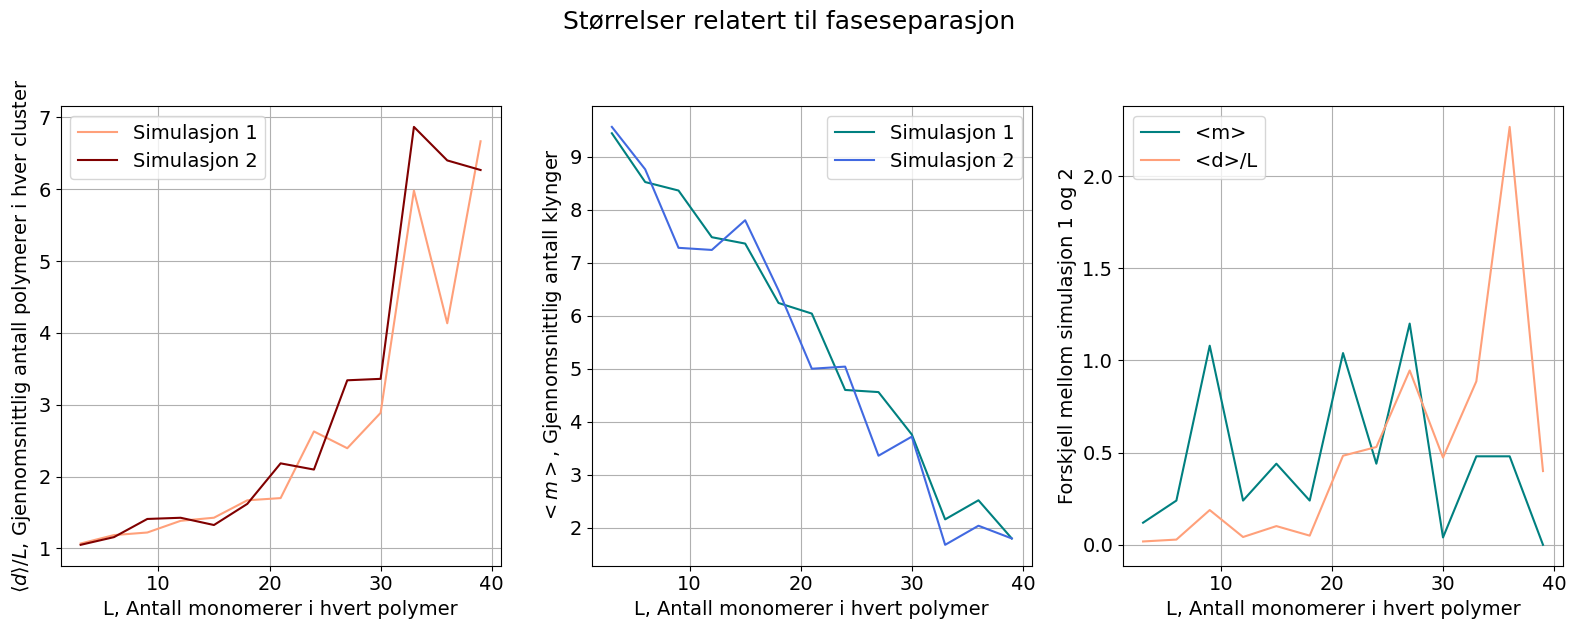

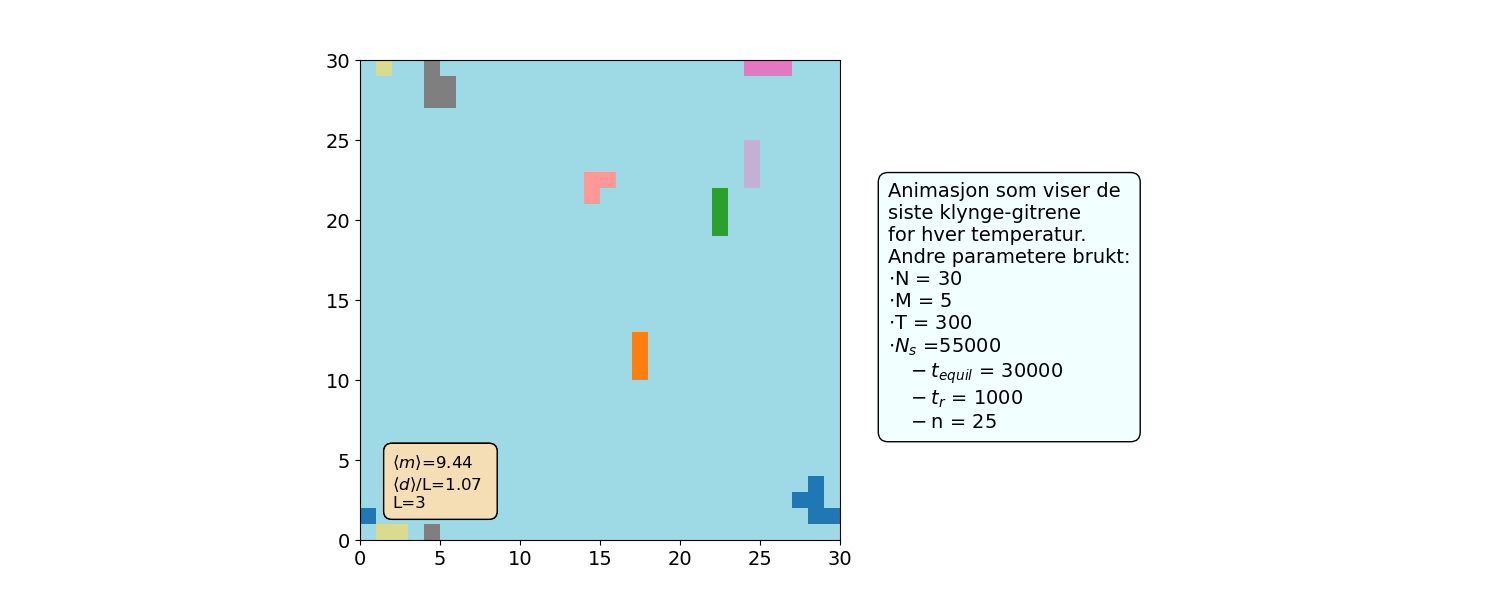

In [18]:
#Analogous to our way of estimating the expected value of d for monomer systems (find_d)

@jit(nopython=True)
def find_d_per_L_and_m_for_cluster_grid(N, M, T, t_r, n, L, t_equil):
    sum_m = 0
    sum_d = 0
    initial_grid = create_polymer_grid(L, N, M)
    epsilon, grid_at_equilibrium = Monte_Carlo_final(t_equil, T, initial_grid, "medium_flexibility")
    
    for i in range(0, n):
        cluster_grid = create_cluster_grid(grid_at_equilibrium)
        m = np.amax(cluster_grid) #Number of clusters
        sum_d += 2*M*L/m
        sum_m += m
        epsilon, grid_at_equilibrium = Monte_Carlo_final(t_r, T, grid_at_equilibrium, "medium_flexibility") #takes the grid at equilibrium as input
    mean_m = sum_m/n
    mean_d = sum_d/n
    mean_d_per_L = mean_d/L
    return mean_d_per_L, mean_m , cluster_grid

T = 300
t_equil = 30000
t_r = 1000
N = 30
M = 5
n = 25

L_lower = 3
L_upper = 39
N_values = 13 #Number of values for L

L_array = np.linspace(L_lower, L_upper, N_values, endpoint = True, dtype = np.dtype("i2"))
d_per_L_array_1 = np.zeros(N_values)
d_per_L_array_2 = np.zeros(N_values)
m_array_1 = np.zeros(N_values)
m_array_2 = np.zeros(N_values)
cluster_grids = np.zeros((N_values,N,N))

for i in range(N_values):
    L = L_array[i]
    d_per_L_1, m_1 , cluster_grid = find_d_per_L_and_m_for_cluster_grid(N, M, T, t_r, n, L, t_equil)
    d_per_L_2, m_2 , cluster_grid_2 = find_d_per_L_and_m_for_cluster_grid(N, M, T, t_r, n, L, t_equil)

    d_per_L_array_1[i] = d_per_L_1
    d_per_L_array_2[i] = d_per_L_2
    m_array_1[i] = m_1
    m_array_2[i] = m_2
    cluster_grids[i] = cluster_grid

#Plot
plt.figure(figsize=(16,6))
plt.suptitle("Størrelser relatert til faseseparasjon", y=1.05)
plt.subplot(1,3,1)
plt.plot(L_array, d_per_L_array_1, color = "lightsalmon", label = "Simulasjon 1")
plt.plot(L_array, d_per_L_array_2, color = "maroon",  label = "Simulasjon 2")
plt.xlabel("L, Antall monomerer i hvert polymer")
plt.ylabel(r"$\langle d \rangle /L$, Gjennomsnittlig antall polymerer i hver cluster")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(L_array, m_array_1, color = "teal",  label = "Simulasjon 1")
plt.plot(L_array, m_array_2, color = "royalblue",  label = "Simulasjon 2")
plt.xlabel("L, Antall monomerer i hvert polymer")
plt.ylabel(r"$<m>$, Gjennomsnittlig antall klynger")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(L_array, np.abs(m_array_1-m_array_2), label = "<m>", color = "teal")
plt.plot(L_array, np.abs(d_per_L_array_1-d_per_L_array_2), label = "<d>/L", color = "lightsalmon")
plt.xlabel("L, Antall monomerer i hvert polymer")
plt.ylabel("Forskjell mellom simulasjon 1 og 2")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#Animation based on the data from the first simulation. As before, the grids are the final grids after the MC-process for each L
#Creates animation
fig, ax = plt.subplots(figsize=(15,6))
"""
def animate(i):
    ax.pcolormesh(cluster_grids[i][::-1,], cmap = "tab20_r" )
    ax.text(2, 2, r"$\langle m \rangle$="+f"{round(m_array_1[i],2)}\n"+r"$\langle d \rangle$/L="+f"{str(round(d_per_L_array_1[i],2)).ljust(6)}\nL={L_array[i]}", size=12, bbox=dict(boxstyle="round, pad=0.5",fc="wheat"))
    ax.axis("image")
    ax.set_position([0,0.1,0.8,0.8])
anim = animation.FuncAnimation(fig, animate, interval=1500, frames=N_values)
ax.text(33, 7, f"Animasjon som viser de\nsiste klynge-gitrene\nfor hver temperatur.\nAndre parametere brukt:\n"+
            r"$\cdot$N"+f" = {N}\n"+r"$\cdot$M "+f"= {M}\n"+r"$\cdot$T = "+f"{T}\n"+r"$\cdot N_s$ ="+f"{t_equil+t_r*n}\n"+r"$\quad -t_{equil}$"+
            f" = {t_equil}\n"+r"$\quad -t_r$"+f" = {t_r}\n"+r"$\quad -$n "+f"= {n}", 
            size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
anim.save('animasjon_faseseparasjon.gif', writer='ffmpeg')
"""
#Displays animation
with open('animasjon_faseseparasjon.gif','rb') as file:
    display(Image(file.read()))
plt.close()

Grunnen til at disse klyngene av polymerer interesserer oss, er at det er nettopp disse som utgjør strukturer vi nevnte innledningsvis, som for eksempel ribosomer og p-granuler. Polymerers evne til å endre form har vist seg som en nyttig egenskap for å oppnå elektrisk stabile klyngestrukturer. Det er akkurat disse klyngestrukturene vi har studert gjennom prosjektet. Fra starten med relativt enkle strukturer som monomerer har vi sett hvordan vi kan simulere tilfeldige prosesser. Monte Carlo-simulasjonene har vist seg å være et nyttig verktøy, da dette gir oss en måte å etterligne naturens tilfeldige og kaotiske væremåte.  

Ved å løfte blikket har vi så blitt i stand til å si noe om interaksjoner mellom polymerer, og hva slags strukturer de gjerne innretter seg i. Her har vi spesielt sett på hvordan parametere som temperatur og polymerisasjonsgrad (L) kan påvirke dannelsen av klynger av polymerer. Temperaturen har for eksempel vist seg viktig i statistiske betraktninger ved at ikke bare bevegelser som minimerer energien er mulig for systemet, men også tilfeller hvor energien øker på grunn av termiske svingninger. Slik har vi, ved hjelp av kjente og ukjente metoder, fått økt innsikt i et for oss ukjent system, cellene.  

 

**Kilder:**

Bracha, D., Walls, M., & Brangwynne, C. (2019). Probing and engineering liquid-phase organelles. Nature Biotechnology, 37(12), 1435-1445. doi: 10.1038/s41587-019-0341-6 

Gregers, Tone Fredsvik (2021, 18. juli). Cellemembraner i Store medisinske leksikon på snl.no. fra https://sml.snl.no/cellemembraner 